# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
# загрузка данных
data = pd.read_csv('/datasets/autos.csv')
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
# посмотрю сколько тут общих дубликатов
print('Общих дубликатов:', data.duplicated().sum())

Общих дубликатов: 4


In [4]:
# количественные характеристики датасета
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Выводы по данным**

- Price - есть минимальная цена 0.
- RegistrationYear есть некорректные значения года регистрации.
- Power - есть некорректные значения мощности двигателя.
- Kilometer 50% с пробегом 150 000. Выше этой цифры значений нет, как будто какое-то ограничение на платформе.
- RegistrationMonth - есть пропуски в месяце регистрации.


**Признаки, которые могут быть значимы для построения прогноза:**

- VehicleType. Тип кузова влияет на функционал автомобиля, а значит на стоимость.
- RegistrationYear. Год выпуска машины обратно пропорционален цене. Если это конечно не ретро автомобиль.
- Gearbox. Разные коробки передач имеют разную надежность и популярность.
- Power. Мощность в лошадиных силах напрямую влияет на цену.
- Model и Brand. Бренд и модель могут существенно влиять на цену при прочих равных характеристиках.
- Kilometer. Чем больше пробег, тем меньше цена.
- FuelType. Тип топлива влияет на пользовательские предпочтения.
- Repaired. Битая машина теряет в цене.

In [5]:
# создам новый датафрейм с нужными столбцами для построения моделей
df = data.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'],axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [6]:
df.info()
# типы данных в столбцах корректные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
df.duplicated().sum()
#45 тысяч общих дубликатов, удалю их

45040

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

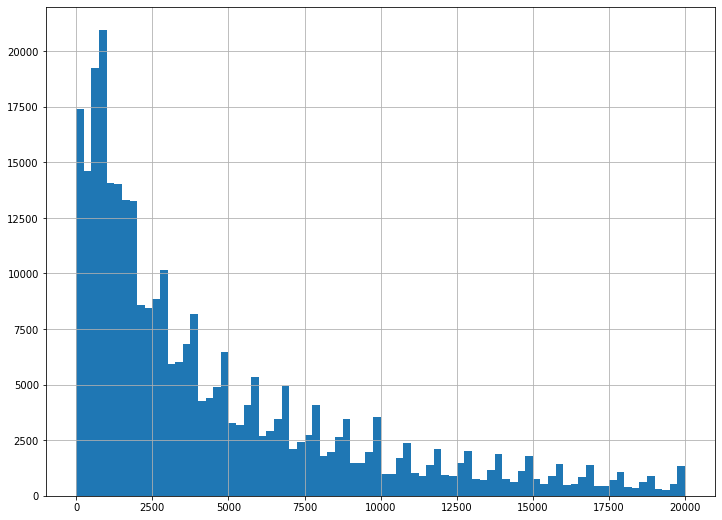

In [9]:
#теперь посмотрю целевой признак
df['Price'].hist(bins=80, figsize=(12,9));

In [10]:
df.query('Price ==0')
#почти 9 тысяч строк с нулевой ценой. Их тоже придется удалить

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [11]:
df = df.query('Price !=0')
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,300425.000000,300425.000000,300425.000000,300425.000000
mean,4619.921098,2004.244916,111.722247,127307.464425
std,4565.205287,83.004128,199.047743,38220.756977
min,1.000000,1000.000000,0.000000,5000.000000
25%,1200.000000,1999.000000,69.000000,125000.000000
50%,2900.000000,2003.000000,105.000000,150000.000000
75%,6650.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


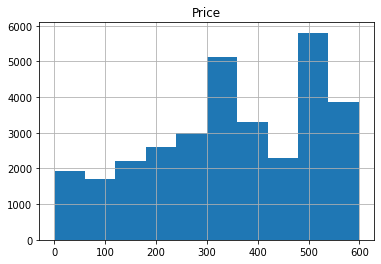

In [12]:
df.query('Price <600').hist('Price');
#исходя из логики, машины дешевле 100 евро кажется нереалистичным вариантом. Для целей моделирования уберу эти значения

In [13]:
df = df.query('Price >100')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297109 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297109 non-null  int64 
 1   VehicleType       266807 non-null  object
 2   RegistrationYear  297109 non-null  int64 
 3   Gearbox           282846 non-null  object
 4   Power             297109 non-null  int64 
 5   Model             280997 non-null  object
 6   Kilometer         297109 non-null  int64 
 7   FuelType          270363 non-null  object
 8   Brand             297109 non-null  object
 9   Repaired          238630 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


С ценой разобрался. Теперь пройдусь по остальным столбцам:
- VehicleType - поищу аналогичные модели и заполню пропуски
- Gearbox - аналогичные модели
- FuelType - аналогичные модели
- Repaired - для всех пропусков установлю значение no
- Model - для всех пропусков установилю значение 'unknown'.

In [14]:
#VehicleType
#сделаю сводную таблицу, найду популярные типы кузова по каждой модели и заполню пропуски
vt_pivot = df.pivot_table(index='Model',columns = 'VehicleType',values='Kilometer',aggfunc='count')
type = vt_pivot.idxmax(axis=1)
mapped_types = df['Model'].map(type)
df['VehicleType'] = df['VehicleType'].fillna(mapped_types)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297109 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297109 non-null  int64 
 1   VehicleType       292201 non-null  object
 2   RegistrationYear  297109 non-null  int64 
 3   Gearbox           282846 non-null  object
 4   Power             297109 non-null  int64 
 5   Model             280997 non-null  object
 6   Kilometer         297109 non-null  int64 
 7   FuelType          270363 non-null  object
 8   Brand             297109 non-null  object
 9   Repaired          238630 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


In [15]:
#Gearbox
gb_pivot = df.pivot_table(index='Model',columns = 'Gearbox',values='Kilometer',aggfunc='count')
gearbox = vt_pivot.idxmax(axis=1)
mapped_gearbox = df['Model'].map(gearbox)
df['Gearbox'] = df['Gearbox'].fillna(mapped_gearbox)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297109 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297109 non-null  int64 
 1   VehicleType       292201 non-null  object
 2   RegistrationYear  297109 non-null  int64 
 3   Gearbox           294587 non-null  object
 4   Power             297109 non-null  int64 
 5   Model             280997 non-null  object
 6   Kilometer         297109 non-null  int64 
 7   FuelType          270363 non-null  object
 8   Brand             297109 non-null  object
 9   Repaired          238630 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


In [16]:
#FuelType
ft_pivot = df.pivot_table(index='Model',columns = 'FuelType',values='Kilometer',aggfunc='count')
FuelType = vt_pivot.idxmax(axis=1)
mapped_fueltype = df['Model'].map(FuelType)
df['FuelType'] = df['FuelType'].fillna(mapped_fueltype)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297109 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297109 non-null  int64 
 1   VehicleType       292201 non-null  object
 2   RegistrationYear  297109 non-null  int64 
 3   Gearbox           294587 non-null  object
 4   Power             297109 non-null  int64 
 5   Model             280997 non-null  object
 6   Kilometer         297109 non-null  int64 
 7   FuelType          291898 non-null  object
 8   Brand             297109 non-null  object
 9   Repaired          238630 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


In [17]:
#Repaired
df['Repaired'] = df['Repaired'].fillna('no')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297109 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297109 non-null  int64 
 1   VehicleType       292201 non-null  object
 2   RegistrationYear  297109 non-null  int64 
 3   Gearbox           294587 non-null  object
 4   Power             297109 non-null  int64 
 5   Model             280997 non-null  object
 6   Kilometer         297109 non-null  int64 
 7   FuelType          291898 non-null  object
 8   Brand             297109 non-null  object
 9   Repaired          297109 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


In [18]:
#Model
df['Model'] = df['Model'].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297109 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297109 non-null  int64 
 1   VehicleType       292201 non-null  object
 2   RegistrationYear  297109 non-null  int64 
 3   Gearbox           294587 non-null  object
 4   Power             297109 non-null  int64 
 5   Model             297109 non-null  object
 6   Kilometer         297109 non-null  int64 
 7   FuelType          291898 non-null  object
 8   Brand             297109 non-null  object
 9   Repaired          297109 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


In [19]:
#все значения заполнить не удалось, оставшиеся пропуски придется просто удалить
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289330 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             289330 non-null  int64 
 1   VehicleType       289330 non-null  object
 2   RegistrationYear  289330 non-null  int64 
 3   Gearbox           289330 non-null  object
 4   Power             289330 non-null  int64 
 5   Model             289330 non-null  object
 6   Kilometer         289330 non-null  int64 
 7   FuelType          289330 non-null  object
 8   Brand             289330 non-null  object
 9   Repaired          289330 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [20]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,289330.000000,289330.000000,289330.000000,289330.000000
mean,4721.915073,2003.771071,113.382335,127559.361283
std,4580.191970,58.238646,199.907704,37638.744802
min,101.000000,1000.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,73.000000,125000.000000
50%,2999.000000,2003.000000,105.000000,150000.000000
75%,6800.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


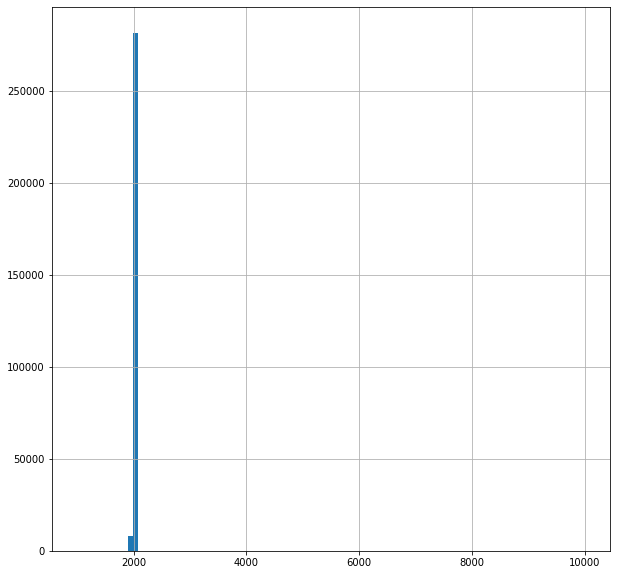

In [21]:
#посмотрю данные по году - там минимальное значение 1000
df['RegistrationYear'].hist(bins=100,figsize=(10,10));

<AxesSubplot:>

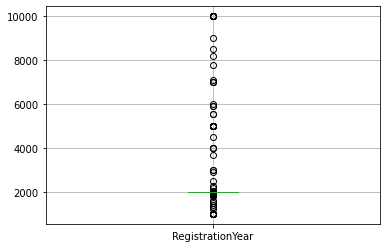

In [22]:
display(df.boxplot('RegistrationYear'))

In [23]:
#ящик с усами показывает, что много выбросов. Оставлю "период" с 1980 по 2024 год
df = df.query('1980 < RegistrationYear <2024')
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,286204.000000,286204.000000,286204.000000,286204.000000
mean,4692.203268,2003.581956,113.724385,127996.289360
std,4561.121871,6.491594,198.488167,37217.697084
min,101.000000,1981.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,75.000000,125000.000000
50%,2999.000000,2003.000000,105.000000,150000.000000
75%,6790.000000,2008.000000,143.000000,150000.000000
max,20000.000000,2019.000000,20000.000000,150000.000000


<AxesSubplot:>

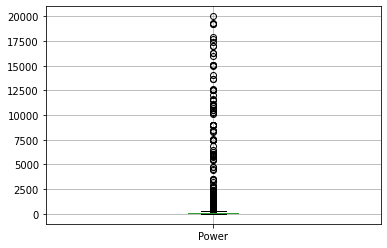

In [24]:
#теперь посмотрю нулевые знаения по мощности двигателей
df.boxplot('Power')

In [25]:
#опять много выбросов. Оставлю интервал (0,500)
df = df.query('0<Power<500')
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,258323.000000,258323.000000,258323.000000,258323.000000
mean,4926.545755,2003.628086,121.368484,127637.008706
std,4625.459898,6.339382,53.233871,37056.149137
min,101.000000,1981.000000,1.000000,5000.000000
25%,1400.000000,1999.000000,80.000000,125000.000000
50%,3290.000000,2004.000000,114.000000,150000.000000
75%,7000.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2019.000000,490.000000,150000.000000


**Вывод**

Данные обработаны. Я убрал аномалии, заполнил пропуски, где это было возможно.

Оставил необходимые для обучения модели столбцы, убрал лишние.

## Обучение моделей

In [26]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

cat_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']
num_columns = ['RegistrationYear','Power','Kilometer']

# Делаю разбивку на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Price'], axis=1),
    df['Price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    )

# Кодирование категориальных признаков для линейной регрессии - OneHotEncoder
encoder = OneHotEncoder(drop='first',sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_columns])
X_test_ohe = encoder.transform(X_test[cat_columns])

encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_num = X_train[num_columns].reset_index()
X_test_num = X_test[num_columns].reset_index()

X_train_lr = pd.concat([X_train_ohe, X_train_num], axis=1)
X_test_lr = pd.concat([X_test_ohe, X_test_num], axis=1)
# X_train_lr
# X_test_lr

# Кодирование категориальных признаков для остальных моделей - OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan)
X_train_oe = encoder.fit_transform(X_train[cat_columns])
X_test_oe = encoder.transform(X_test[cat_columns])


encoder_col_names = cat_columns

X_train_oe = pd.DataFrame(X_train_oe, columns=encoder_col_names)
X_test_oe = pd.DataFrame(X_test_oe, columns=encoder_col_names)
X_train_num = X_train[num_columns].reset_index()
X_test_num = X_test[num_columns].reset_index()

X_train = pd.concat([X_train_oe, X_train_num], axis=1)
X_test = pd.concat([X_test_oe, X_test_num], axis=1)

# X_train
X_test

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,index,RegistrationYear,Power,Kilometer
0,2.0,4.0,74.0,9.0,20.0,0.0,9676,2002,163,150000
1,4.0,4.0,116.0,9.0,38.0,0.0,206634,1998,90,150000
2,0.0,4.0,166.0,5.0,27.0,0.0,335718,2006,101,150000
3,7.0,4.0,29.0,5.0,1.0,0.0,310383,2006,140,150000
4,7.0,4.0,44.0,5.0,36.0,0.0,26754,2012,124,70000
...,...,...,...,...,...,...,...,...,...,...
64576,4.0,4.0,42.0,9.0,24.0,0.0,34746,1999,75,125000
64577,5.0,4.0,8.0,9.0,25.0,0.0,73559,2010,75,100000
64578,0.0,0.0,220.0,9.0,38.0,0.0,258170,2005,115,125000
64579,7.0,4.0,228.0,5.0,39.0,0.0,213855,2002,116,150000


Выборки подготовлены, разбиты на тренировочную и тестовую, категориальные признаки закодированы. Теперь перейду к обучению моделей. Так же создам фунцию для оценки метрики RMSE.

In [27]:
# Создаю функцию для RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Создам объект-скорер для RMSE
scorer = make_scorer(rmse, greater_is_better=False)

**Линейная регрессия**

In [28]:
%%time

# Создаем регрессор
regressor = LinearRegression()

# Определяем гиперпараметры для поиска
hyperparams = {}

# Создаем GridSearchCV
clf = GridSearchCV(regressor, hyperparams, scoring=scorer, return_train_score=True)

# Обучаем модель и выполняем кросс-валидацию
clf.fit(X_train_lr, y_train)

# Извлекаем результаты из cv_results_
results = clf.cv_results_

# Извлекаем лучшие параметры и RMSE
best_params = clf.best_params_
best_rmse_LR = -clf.best_score_

# Извлекаем время обучения и предсказания из cv_results_
mean_fit_time_LR = results['mean_fit_time']
mean_score_time_LR = results['mean_score_time']

# Выводим результаты
print("Лучшие параметры:")
print(best_params)
print()
print("Лучшее RMSE:", best_rmse_LR)
print()
print("Среднее время обучения (сек):", mean_fit_time_LR)
print("Среднее время предсказания (сек):", mean_score_time_LR)

Лучшие параметры:
{}

Лучшее RMSE: 2581.4431277401986

Среднее время обучения (сек): [15.45257874]
Среднее время предсказания (сек): [0.16888208]
CPU times: user 1min 15s, sys: 25.3 s, total: 1min 40s
Wall time: 1min 40s


**DecissionTree регрессия**

In [29]:
%%time

# Создаем регрессор и список значений max_depth
regressor = DecisionTreeRegressor()
max_depth_list = [x for x in range(2, 10)]

# Задаем гиперпараметры для GridSearchCV
hyperparams = [{'criterion': ['mse'], 
                'max_depth': max_depth_list, 
                'random_state': [RANDOM_STATE]}]

# Создаем GridSearchCV
clf = GridSearchCV(regressor, hyperparams, scoring=scorer, return_train_score=True)

# Обучаем модель и выполняем кросс-валидацию
clf.fit(X_train, y_train)

# Извлекаем результаты из cv_results_
results = clf.cv_results_

# Извлекаем лучшие параметры и RMSE
best_params = clf.best_params_
best_rmse_DT = -clf.best_score_

# Извлекаем время обучения и предсказания из cv_results_
mean_fit_time_DT = results['mean_fit_time']
mean_score_time_DT = results['mean_score_time']

# Выводим результаты
print("Лучшие параметры:")
print(best_params)
print()
print("Лучшее RMSE:", best_rmse_DT)
print()
print("Среднее время обучения (сек):", mean_fit_time_DT)
print("Среднее время предсказания (сек):", mean_score_time_DT)


Лучшие параметры:
{'criterion': 'mse', 'max_depth': 9, 'random_state': 42}

Лучшее RMSE: 2043.043617080203

Среднее время обучения (сек): [0.13373938 0.17415676 0.22413297 0.27282677 0.31540408 0.35963354
 0.39893064 0.45155725]
Среднее время предсказания (сек): [0.00402002 0.004423   0.0046586  0.00513048 0.00508747 0.00568991
 0.0061336  0.00629706]
CPU times: user 13 s, sys: 0 ns, total: 13 s
Wall time: 13 s


**Регрессия CatBoostRegressor**

In [30]:
%%time

# Модель на данных, закодированных по методу OE

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.3, 0.6],
                'random_state':[RANDOM_STATE],
                'verbose':[False]}]

# Создаем GridSearchCV
clf = GridSearchCV(regressor, hyperparams, scoring=scorer, return_train_score=True)

# Обучаем модель и выполняем кросс-валидацию
clf.fit(X_train, y_train)

# Извлекаем результаты из cv_results_
results = clf.cv_results_

# Извлекаем лучшие параметры и RMSE
best_params = clf.best_params_
best_rmse_CB = -clf.best_score_

# Извлекаем время обучения и предсказания из cv_results_
mean_fit_time_CB = results['mean_fit_time']
mean_score_time_CB = results['mean_score_time']

# Выводим результаты
print("Лучшие параметры:")
print(best_params)
print()
print("Лучшее RMSE:", best_rmse_CB)
print()
print("Среднее время обучения (сек):", mean_fit_time_CB)
print("Среднее время предсказания (сек):", mean_score_time_CB)

Лучшие параметры:
{'learning_rate': 0.3, 'random_state': 42, 'verbose': False}

Лучшее RMSE: 1590.8947268927695

Среднее время обучения (сек): [22.30264254 22.21101546]
Среднее время предсказания (сек): [0.04316664 0.04341526]
CPU times: user 4min 3s, sys: 0 ns, total: 4min 3s
Wall time: 4min 12s


<!-- Модель CatBoostRegressor в конечном итоге у меня не обучилась, Jupyter не рассчитывает результат. -->

**Регрессия LGBM**

In [31]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[RANDOM_STATE]}]

# Создаем GridSearchCV
clf = GridSearchCV(regressor, hyperparams, scoring=scorer, return_train_score=True)

# Обучаем модель и выполняем кросс-валидацию
clf.fit(X_train, y_train)

# Извлекаем результаты из cv_results_
results = clf.cv_results_

# Извлекаем лучшие параметры и RMSE
best_params = clf.best_params_
best_rmse_LGBM = -clf.best_score_

# Извлекаем время обучения и предсказания из cv_results_
mean_fit_time_LGBM = results['mean_fit_time']
mean_score_time_LGBM = results['mean_score_time']

# Выводим результаты
print("Лучшие параметры:")
print(best_params)
print()
print("Лучшее RMSE:", best_rmse_LGBM)
print()
print("Среднее время обучения (сек):", mean_fit_time_LGBM)
print("Среднее время предсказания (сек):", mean_score_time_LGBM)

Лучшие параметры:
{'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 42}

Лучшее RMSE: 1611.1563962289908

Среднее время обучения (сек): [2.98047361 5.46310091 7.85587049]
Среднее время предсказания (сек): [0.27609277 0.26569576 0.30411563]
CPU times: user 1min 48s, sys: 0 ns, total: 1min 48s
Wall time: 1min 49s


В итоге результаты подбора параметров следующие:
- DecissionTree {'criterion': 'mse', 'max_depth': 9, 'random_state': 42}
- CatBoostRegressor {'learning_rate': 0.3, 'random_state': 42, 'verbose': False}
- LGBM {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 42}

## Анализ моделей

In [44]:
# Сведу все полученные результаты в одном месте
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'Время обучения, сек':[mean_fit_time_LR[0],
                              mean_fit_time_DT[7],
                              mean_fit_time_CB[0],
                              mean_fit_time_LGBM[2]],
        'Время предсказания, сек':[mean_score_time_LR[0],
                                  mean_score_time_DT[7],
                                  mean_score_time_CB[0],
                                  mean_score_time_LGBM[2]],
        'RMSE, евро':[best_rmse_LR,
                                                best_rmse_DT,
                                                best_rmse_CB,
                                                best_rmse_LGBM]}
scores_data = pd.DataFrame(data=data, index=index)
scores_data.sort_values(by='Время обучения, сек')

,"Время обучения, сек","Время предсказания, сек","RMSE, евро"
DecisionTreeRegressor,0.451557,0.006297,2043.043617
LGBMRegressor,7.855870,0.304116,1611.156396
LinearRegression,15.452579,0.168882,2581.443128
CatBoostRegressor,22.302643,0.043167,1590.894727


Лучшая модель по времени обучения и предсказания - Дерево решений. RMSE подходит под критерий - меньше 2500. На этой модели с лучшими параметрами проверю качество на тестовой выборке. 

In [45]:
%%time

# Обучение
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=9, 
                              random_state=RANDOM_STATE) 
model.fit(X_train, y_train)

CPU times: user 553 ms, sys: 0 ns, total: 553 ms
Wall time: 552 ms


DecisionTreeRegressor(max_depth=9, random_state=42)

In [46]:
%%time

# Предсказание
prediction = model.predict(X_test)

CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 8.93 ms


In [47]:
# Метрика RMSE
final_RMSE_DTR = mean_squared_error(y_test, prediction) ** 0.5
final_RMSE_DTR

2042.4691463665426

На тестовой выборке лучшая модель показала такие же хорошие результаты:
- Время обучения 577 мс (VS 445 мс на кросс-валидации)
- Время предсказания 11 мс (VS 6 мс на кросс-валидации)
- RMSE 2042 (VS 2043 на кросс-валидации)

# Выводы

Я рассмотрел 4 модели: линейная регрессия, дерево решений, градиентный бустинг и LightGBM.

У заказчика 3 главных критерия: качество предсказания, время обучения и предсказания.
В итоговой таблице приведены сравнительные характеристики 4-х моделей. Исходя из критериев, быстрее всего обучается линейная регрессия. Но она дает не точный результат - RMSE больше заявленных 2500.
Дерево решений дает отличный результат предсказания и небольшое время обучения.
Самый точный результат дает CatBoostRegressor, однако и время обучения у нее самое большое.

Как итог, следует выбрать модель **Дерева решений**. Мгновенное обучение и предсказание, что важно для использования в приложении. А так же хорошая точност предсказания - RMSE 2042 при пороговом значении <2500.